In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
from pathlib import Path 
import matplotlib.pyplot as plt 
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [120]:
from fastai.vision import *
from fastai import *

In [8]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_val2012.json')]

In [17]:
# open files with json and get keys
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [18]:
# list first five examples of images 
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [19]:
# list first two examples of annotations
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [20]:
# read data with categories 
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [41]:
# munge data into dictionary with dictionary comprehension 
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

# dictionary with id as key and name as value for each category 
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [42]:
# dictionary with id as key and filenames as value for each image
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}

In [43]:
# dictionary with id as key 
trn_ids = {o[ID] for o in trn_j[IMAGES]}

In [74]:
# define function to convert height/width into topleft/bottomright and switch x/y coords to be consistent with numpy 
def hw_bb(bb): 
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

In [75]:
# create a defaultdict with IMG_ID as key and list of bbox coordinates and category_id as value
import collections
import numpy as np
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o['image_id']].append((bb, o[CAT_ID]))

In [76]:
# view one image with its annotations
trn_anno[23]

[(array([229,   8, 499, 244]), 2),
 (array([219, 229, 499, 333]), 2),
 (array([  0,   1, 368, 116]), 15),
 (array([  1,   2, 461, 242]), 15),
 (array([  0, 224, 485, 333]), 15)]

In [77]:
cats[2],cats[15]

('bicycle', 'person')

In [78]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [79]:
cats[15],cats[13]

('person', 'horse')

In [80]:
#convert back to VOC bounding boxes when required 
bb_voc = [155, 96, 196, 174]
bb_fast_ai = hw_bb(bb_voc)
bb_fast_ai

array([ 96, 155, 269, 350])

In [84]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

In [85]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fast_ai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

In [102]:
path = Path('data/VOCdevkit_train/VOC2007')
list(path.iterdir())

[PosixPath('data/VOCdevkit_train/VOC2007/ImageSets'),
 PosixPath('data/VOCdevkit_train/VOC2007/SegmentationClass'),
 PosixPath('data/VOCdevkit_train/VOC2007/SegmentationObject'),
 PosixPath('data/VOCdevkit_train/VOC2007/Annotations'),
 PosixPath('data/VOCdevkit_train/VOC2007/JPEGImages')]

In [109]:
JPEGS = 'JPEGImages'
IMG_PATH = path/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/VOCdevkit_train/VOC2007/JPEGImages/003301.jpg'),
 PosixPath('data/VOCdevkit_train/VOC2007/JPEGImages/006279.jpg'),
 PosixPath('data/VOCdevkit_train/VOC2007/JPEGImages/008254.jpg'),
 PosixPath('data/VOCdevkit_train/VOC2007/JPEGImages/007167.jpg'),
 PosixPath('data/VOCdevkit_train/VOC2007/JPEGImages/000608.jpg')]

In [110]:
trn_j[IMAGES][0]

{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}

In [144]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [145]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [146]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [147]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [148]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

In [149]:
list(path.iterdir())

[PosixPath('data/VOCdevkit_train/VOC2007/ImageSets'),
 PosixPath('data/VOCdevkit_train/VOC2007/SegmentationClass'),
 PosixPath('data/VOCdevkit_train/VOC2007/SegmentationObject'),
 PosixPath('data/VOCdevkit_train/VOC2007/Annotations'),
 PosixPath('data/VOCdevkit_train/VOC2007/JPEGImages')]

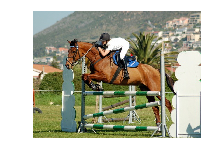

In [150]:
img = open_image(str(IMG_PATH/trn_fns[17]))
show_image(img)

torch.Size([3, 364, 480])


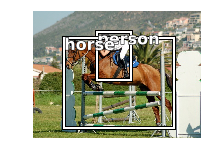

In [151]:
def draw_im(im, ann):
    ax = show_image(im)
    for b, c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
        
def draw_idx(i, IMG_PATH):
    im_a = trn_anno[i]
    im = open_image(str(IMG_PATH/trn_fns[i]))
    print(im.shape)
    draw_im(im, im_a)
    
draw_idx(17, IMG_PATH)

In [192]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [193]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}


Exception: 

In [195]:
??ImageClassifierData.from_csv()

Object `ImageClassifierData.from_csv` not found.
